In [1]:
# Basic imports
import numpy as np
import pandas as pd

from dataframe.csv_utils import (
    load_data_from_csv,
    get_filtered_data,
)

# sklearn imports
from sklearn.decomposition import PCA  # Principal Component Analysis
from sklearn.manifold import TSNE  # T-Distributed Stochastic Neighbor Embedding

# plotly imports
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode

SORTED_BLOCK_NAMES = [
    "audio_hvha",
    "audio_hvla",
    "audio_nvha",
    "audio_nvla",
    "breath_hvha",
    "breath_hvla",
    "breath_nvha",
    "breath_nvla",
    "meditation",
    "mind wandering",
]

AUDIO_BLOCKS = ["audio_hvha", "audio_hvla", "audio_nvha", "audio_nvla"]

FOUR_CONDITIONS = ["audio"] * 4 + ["breath"] * 4 + ["meditation", "wandering"]
VALENCE_CONDITIONS = (
    ["h_valence"] * 2
    + ["n_valence"] * 2
    + ["h_valence"] * 2
    + ["n_valence"] * 2
    + ["meditation", "wandering"]
)

AROUSAL_CONDITIONS = ["h_arousal", "l_arousal"] * 4 + ["meditation", "wandering"]

In [2]:
"""
    load features from csv
"""
dir_name = "eeg_features2"
result = load_data_from_csv(dir_name)

In [3]:
# This is needed so we can display plotly plots properly
init_notebook_mode(connected=True)


In [4]:
from umap import UMAP

import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots


COLOR_MAP = {
    "audio_hvha": "red",
    "audio_hvla": "magenta",
    "audio_nvha": "green",
    "audio_nvla": "olive",
}
V_COLOR_MAP = {
    "hvha": "red",
    "hvla": "magenta",
    "nvha": "green",
    "nvla": "olive",
    "lvha": "blue",
    "lvla": "steelblue",
}


def get_filter_pattern(feature: str = "ALL", channel: str = "") -> str:
    prefix = ""
    if len(channel) > 0:
        prefix = f"^{channel}"

    # get_other feature_pattern = ".*(?<!GAMMA|BETA2|BETA1|ALPHA|THETA|DELTA)$"
    if feature == "ALL":
        return f"{prefix}.*(?<!sdf)$"

    return f"{prefix}.*{feature}$"  # f"^{feature}.*(?<!BETA2)$"


def get_processed_feature(
    feature: str, channel: str, result: pd.DataFrame, subjects: list = []
):
    pattern = get_filter_pattern(feature, channel)
    normalized_eeg_features, filtered_result, label_list = get_filtered_data(
        result, subjects, pattern
    )
    #print("filtered", normalized_eeg_features.shape)
    return normalized_eeg_features, filtered_result


def get_umap(
    feature: str,
    channel: str,
    result: pd.DataFrame,
    all_blocks: list,
    subjects: list = [],
):
    pattern = get_filter_pattern(feature, channel)
    normalized_eeg_features, filtered_result, label_list = get_filtered_data(
        result, subjects, pattern
    )
    print(normalized_eeg_features.shape)

    # Run UMAP
    umap2d = UMAP(n_components=2, init="random", random_state=0)
    proj_2d = pd.DataFrame(umap2d.fit_transform(normalized_eeg_features))

    # Concatanate the umap points and original data
    filtered_result = filtered_result.reset_index()
    filtered_result["condition"] = all_blocks * len(subjects)
    proj_2d.columns = ["C1_2d", "C2_2d"]
    return pd.concat([filtered_result, proj_2d], axis=1, join="inner")


def get_pca(feature: str, channel: str, result: pd.DataFrame, subjects: list = []):
    normalized_eeg_features, filtered_result = get_processed_feature(
        feature, channel, result, subjects
    )

    # Run PCA
    pca = PCA(n_components=2)
    proj_2d = pd.DataFrame(pca.fit_transform(normalized_eeg_features))

    # Concatanate the umap points and original data
    filtered_result = filtered_result.reset_index()
    proj_2d.columns = ["C1_2d", "C2_2d"]
    return pd.concat([filtered_result["Subject"], proj_2d], axis=1, join="inner")


def show_result(
    feature: str,
    subjects: list,
    plotX: pd.DataFrame,
    conditions: list,
    to_save: bool = False,
):
    title = f"EEG {feature} (average spectral power per trial)"

    figures = []
    for subj in subjects:
        df = plotX[plotX["Subject"] == subj]
        figures.append(
            px.scatter(
                df,
                x="C1_2d",
                y="C2_2d",
                color=df["condition"],
                color_discrete_map=V_COLOR_MAP,
                opacity=0.6,
            )
        )

    fig = make_subplots(
        rows=int((len(figures) / 2) + (len(figures) % 2)),
        cols=2,
        subplot_titles=subjects,
        horizontal_spacing=0.1,
        vertical_spacing=0.05,
    )

    for i, figure in enumerate(figures):
        for trace in range(len(figure["data"])):
            figure["data"][trace].update()
            fig.append_trace(
                figure["data"][trace], row=int(i / 2 + 1), col=int(i % 2 + 1)
            )

    # Deduplicate the legends
    names = set()
    fig.for_each_trace(
        lambda trace: trace.update(showlegend=False)
        if (trace.name in names)
        else names.add(trace.name)
    )

    fig.update_layout(
        height=1000, width=1000, title_text=title, margin=dict(r=0, b=0, l=0)
    )

    name = ",".join(str(s) for s in subjects)
    filename = f"results/{feature}_{name}.png"
    if to_save:
        fig.write_image(filename)

    fig.show()


def show_pca_matrix(
    band: str,
    channel: str,
    subject: int,
    result: pd.DataFrame,
    all_blocks: list,
    n_components: int,
    to_save: bool = False,
):
    normalized_eeg_features, _ = get_processed_feature(band, channel, result, [subject])
    pca = PCA(n_components=n_components)
    proj_2d = pd.DataFrame(pca.fit_transform(normalized_eeg_features))
    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }

    identifier = str(subject) + f"_{band}_{channel}_channel"
    total_var = pca.explained_variance_ratio_.sum() * 100
    fig = px.scatter_matrix(
        proj_2d,
        labels=labels,
        dimensions=range(len(labels)),
        color=all_blocks,
        color_discrete_map=V_COLOR_MAP,
        opacity=0.6,
        title=f"{identifier} Total Explained Variance: {total_var:.2f}%",
    )
    fig.update_traces(diagonal_visible=False)

    # Deduplicate the legends
    names = set()
    fig.for_each_trace(
        lambda trace: trace.update(showlegend=False)
        if (trace.name in names)
        else names.add(trace.name)
    )

    fig.update_layout(height=1000, width=1000, margin=dict(r=0, b=0, l=0))

    filename = f"results/{identifier}_PCA_breakdown.png"
    if to_save:
        fig.write_image(filename)

    fig.show()


2023-04-28 13:29:00.574400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
name_to_batch = {
    "f": [2017, 2018, 2020, 2024, 2025, 2026],
    "s": [2028, 2029, 2031, 2032, 2033, 2035],
    "t": [2036, 2039, 2040, 2041, 2042, 2043, 2044, 2045],
}

# Attach the block conditions
subjects = name_to_batch["s"]
all_blocks = []
for b in SORTED_BLOCK_NAMES:
    all_blocks.extend([b] * 13)

result["condition"] = all_blocks * len(subjects)

In [17]:
mask = result["condition"].isin(AUDIO_BLOCKS)
audio_only = result[mask]
all_blocks = list(result[mask]['condition'])

In [60]:
# True label as user ratings
v_r = audio_only["Valence"].tolist()
a_r = audio_only["Arousal"].tolist()
all_blocks = []
for i in range(audio_only.shape[0]):
    valence = "hv"
    if v_r[i] < 0.4:
        valence = "lv"
    elif v_r[i] < 0.6:
        valence = "nv"

    arousal = "ha" if a_r[i] > 0.5 else "la"
    all_blocks.append(valence + arousal)

audio_only['condition'] = all_blocks

/var/folders/xk/96ygh_6101x5w_7lybf38gsm0000gn/T/ipykernel_82438/176412997.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# https://plotly.com/python/pca-visualization/
for band in ["ALL", "DELTA", "THETA", "ALPHA", "BETA1", "BETA2", "GAMMA"]:
    for ch in ["A", "B", "C", "D"]:
        plotX = get_pca(band, ch, audio_only.drop("condition", axis=1), subjects)
        feature = f"rating_audio_{band}_{ch}_channel_PCA"
        plotX["condition"] = all_blocks
        show_result(feature, subjects, plotX, all_blocks, False)


In [ ]:
n_components = 6
for s in subjects:
    conditions = audio_only[audio_only["Subject"] == s]["condition"]
    show_pca_matrix(
        "ALPHA",
        "C",
        s,
        audio_only.drop("condition", axis=1),
        conditions,
        n_components,
        False,
    )


In [64]:
from sklearn.metrics.cluster import rand_score
from collections import defaultdict


def do_hierarchical_clustering(normalized_eeg_features, n_clusters=4):
    from sklearn.cluster import AgglomerativeClustering
    import time

    print("Compute unstructured hierarchical clustering...")
    st = time.time()
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(
        normalized_eeg_features
    )
    elapsed_time = time.time() - st
    print(f"Elapsed time: {elapsed_time:.2f}s")
    #     print(f"Number of points: {ward.labels_.size}")
    return ward.labels_


def do_kmeans(normalized_eeg_features, n_clusters=4):
    from sklearn.cluster import KMeans

    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=2)
    kmeans.fit(normalized_eeg_features)
    # Find which cluster each data-point belongs to
    return kmeans.predict(normalized_eeg_features)


# reference https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
def get_clustering_result(data, subject, n_clusters, cluster_func, score_func):
    heatmap_data = []
    s = subject
    for ch in ["A", "B", "C", "D"]:
        scores = defaultdict()
        for band in ["ALL", "DELTA", "THETA", "ALPHA", "BETA1", "BETA2", "GAMMA"]:
            normalized_eeg_features, _ = get_processed_feature(
                band, ch, data.drop("condition", axis=1), [s]
            )
            reduced_data = PCA(n_components=0.95).fit_transform(normalized_eeg_features)
            normalized_eeg_features = pd.DataFrame(reduced_data)

            true_labels = audio_only[data["Subject"] == s]["condition"]
            score = score_func(true_labels, cluster_func(normalized_eeg_features, n_clusters))
            # print(f'{band}:{ch}:{score}')
            scores[band] = score
        heatmap_data.append(scores)
    
    return pd.DataFrame(heatmap_data, index=["A", "B", "C", "D"])
    
    
subject_to_heatmap = {}
for s in subjects:
    subject_to_heatmap[s] = get_clustering_result(audio_only, s, 6, do_kmeans, rand_score)

(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 52
(52, 768) 768 

/var/folders/xk/96ygh_6101x5w_7lybf38gsm0000gn/T/ipykernel_82438/2169426051.py:14: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



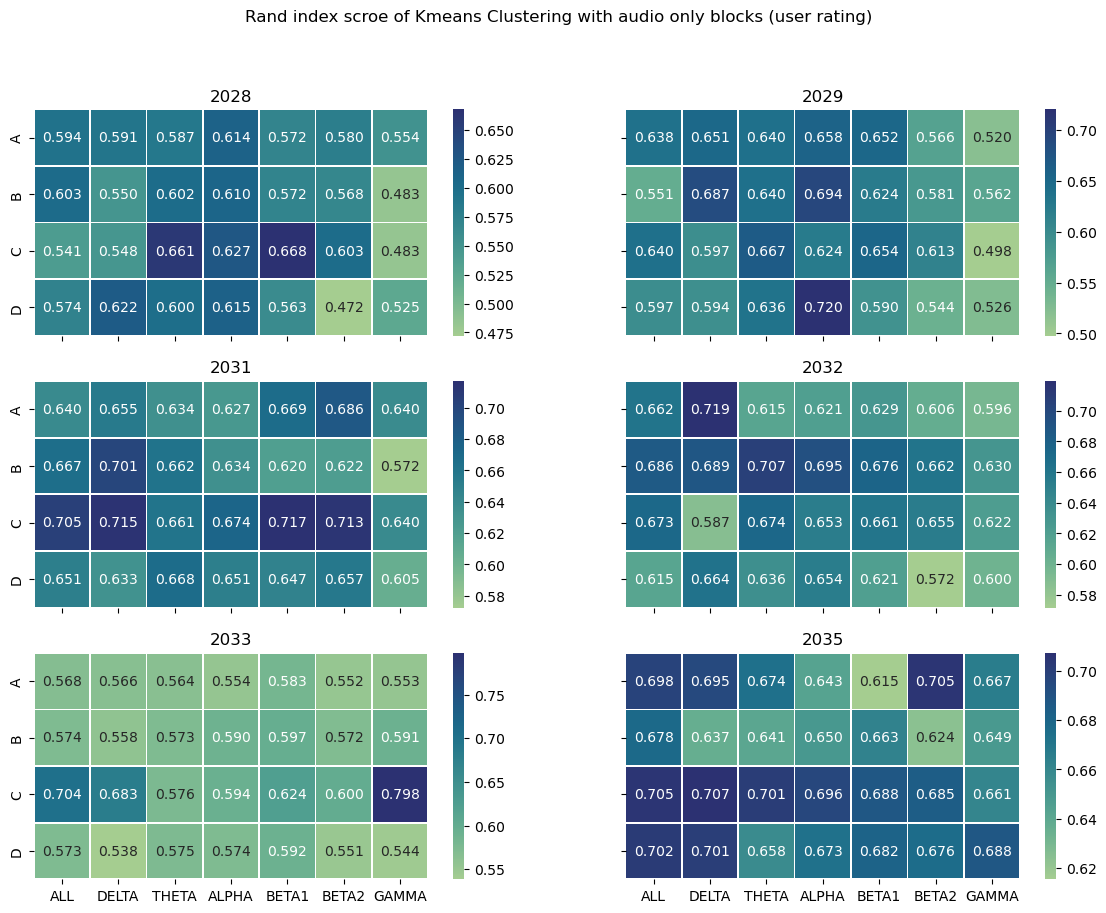

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(14, 10))
fig.suptitle('Rand index scroe of Kmeans Clustering with audio only blocks (user rating)')
for s, ax in zip(subject_to_heatmap.keys(), axes.flatten()):
    ax.set_title(s)
    sns.heatmap(subject_to_heatmap[s], annot=True, fmt=".3f", linewidths=0.5, ax=ax, cmap="crest")
    

identifier = ",".join(str(s) for s in subjects)
filename = f"results/{identifier}_user_rating_rand_index_kmeans_audio_blocks.png"
fig.show()
plt.savefig(filename)

In [40]:
from dataframe.visualization import pca_2d

# Add the cluster vector to our DataFrame, X
normalized_eeg_features["Cluster"] = clusters
# normalized_eeg_features['Block'] = all_blocks

pca_2d(
    normalized_eeg_features,
    4,
    [
        "rgba(255, 128, 255, 0.8)",
        "rgba(255, 128, 2, 0.8)",
        "rgba(0, 255, 200, 0.8)",
        "rgba(0, 128, 200, 0.8)",
    ],
    "hello",
    False,
    mode="markers",
    textfont=dict(size=10),
)

NameError: name 'clusters' is not defined

In [ ]:
for f in ["ALL", "DELTA", "THETA", "ALPHA", "BETA1", "BETA2", "GAMMA"]:
    plotX = get_umap(f, result, all_blocks, subjects)
    feature = f"{f}_UMAP"
    show_result(feature, subjects, plotX, condition)


In [ ]:
# from sklearn.mixture import GaussianMixture
# import matplotlib.pyplot as plt

# gmm = GaussianMixture(n_components=2).fit(normalized_eeg_features)
# clusters = gmm.predict(normalized_eeg_features)


In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn import metrics

# db = DBSCAN(eps=7, min_samples=10).fit(normalized_eeg_features)
# clusters = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
# n_noise_ = list(clusters).count(-1)

# print("Estimated number of clusters: %d" % n_clusters_)
# print("Estimated number of noise points: %d" % n_noise_)
# clusters
